# Augmentation on multiple CPU cores

Augmentation can be a slow process, especially when working with large images and when combining many different augmentation techniques. Take a look at the [performance documentation](https://imgaug.readthedocs.io/en/latest/source/performance.html) for some lower bounds on the expected single core performance using outdated hardware.

One way to improve performance is to augment simultaneously on multiple CPU cores. `imgaug` offers a native system to do that. It is based on roughly the following steps:
  1. Split the dataset into batches. Each batch contains one or more images and the additional data associated with them, e.g. bounding boxes or segmentation maps. (Splitting the data can also be done on the fly using a generator.)
  2. Start one or more child processes. Each of them runs on its own CPU core.
  3. Send batches to the child processes. Try to distribute them equally over the child processes so that each of them has a similar amount of work to do.
  4. Let the child processes augment the data.
  5. Receive the augmented batches from the child processes.
A few important points can be derived from these steps. First, the data has to be split into batches. Second, combining all data into one batch and using multicore augmentation is pointless, as each individual batch is augmented by exactly one core. Third, using multicore augmentation for small amounts of data can also be pointless as starting the child processes might take up more time than simply augmenting the dataset on a single CPU core. (Though, you can re-use the child processes between epochs, so it might still pay off.)

**Important**: `imgaug` offers multicore features and it is recommended to use them for multicore augmentation. It is **not** recommended to execute `imgaug` in a custom-made multicore routine using e.g. python's `multiprocessing` library or by using the multiprocessing support of some deep learning libraries. Doing so runs a major risk to accidentally apply the same augmentations in each child worker (just to different images). If one still decides to build a custom implementation, make sure to call `imgaug.seed(value)` and `augmenter.reseed(value)` with *different seeds per child process*. Generating debug outputs per child process is then also recommended. Messing this up is easy and hard to even notice.

## Example: augment_batches(..., background=True)

The easiest way to do multicore augmentation in `imgaug` is to call `augment_batches(..., background=True)`. It works similarly to e.g. `augment_images()`. The difference is that it expects a list of `imgaug.augmentables.batches.Batch` or `imgaug.augmentables.batches.UnnormalizedBatch` instances. Each of these instances contains the data of a batch, e.g. images or bounding boxes. Creating a batch is trivial and can be done via e.g. `batch = UnnormalizedBatch(images=<list of numpy arrays>, bounding_boxes=<list of imgaug.BoundingBoxOnImages>)`. Another difference to `augment_images()` is that `augment_batches()` returns a generator, which continuously yields augmented batches as they are received from the child processes. The final (and important) difference is that `augment_batches()` currently does *not* use the random state set in the augmenter, but rather picks a new one. That is because otherwise all child processes would apply the same augmentations (just to different images). If you need more control over the random state use `pool()` or `imgaug.multicore.Pool` instead (see further below).

Let's try to use `augment_batches()`. First, we define some example data.

In [1]:
import numpy as np
import imgaug as ia
%matplotlib inline

BATCH_SIZE = 16
NB_BATCHES = 100

image = ia.quokka_square(size=(256, 256))
images = [np.copy(image) for _ in range(BATCH_SIZE)]

Now we combine the images to `UnnormalizedBatch` instances:

In [2]:
from imgaug.augmentables.batches import UnnormalizedBatch
batches = [UnnormalizedBatch(images=images) for _ in range(NB_BATCHES)]

As the data here is already well normalized, we could also use `imgaug.augmentables.batches.Batch` instead, which has the same interface. If e.g. we had keypoints and these were provided to as lists of xy-tuples, `UnnormalizedBatch` would have to be used and it would convert these lists to `KeypointsOnImage` instances.

Our augmentation sequence contains `PiecewiseAffine`, which tends to be a very slow augmenter. We further slow it down by using a denser grid of points on the image. Each such point will lead to more local affine transformations being applied.

In [3]:
from imgaug import augmenters as iaa

aug = iaa.Sequential([
    iaa.PiecewiseAffine(scale=0.05, nb_cols=6, nb_rows=6),  # very slow
    iaa.Fliplr(0.5),  # very fast
    iaa.CropAndPad(px=(-10, 10))  # very fast
])

Now we augment the generated batches. Let's first augment without multicore augmentation to see how long a single CPU core needs. `augment_batches()` returns a generator of `Batch` instances. We can then access the augmented images via the attribute `UnnormalizedBatch.images_aug`.

Augmentation done in 129.30s


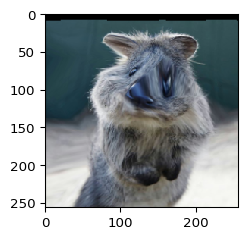

In [4]:
import time

time_start = time.time()
batches_aug = list(aug.augment_batches(batches, background=False))  # list() converts generator to list
time_end = time.time()

print("Augmentation done in %.2fs" % (time_end - time_start,))
ia.imshow(batches_aug[0].images_aug[0])

Roughly 130 seconds for 100 batches, each containing 16 images of size 256x256. That's about 0.08s per image. Not very fast, the GPU would most likely train faster than this. Let's try it instead with multicore augmentation.

Augmentation done in 27.53s


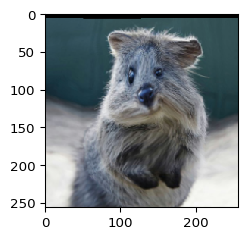

In [5]:
time_start = time.time()
batches_aug = list(aug.augment_batches(batches, background=True))  # background=True for multicore aug
time_end = time.time()

print("Augmentation done in %.2fs" % (time_end - time_start,))
ia.imshow(batches_aug[0].images_aug[0])

Down to less than 30 seconds -- or roughly a quarter of the single core time. That is already much better. Note that this is on an outdated CPU with 4 cores and 8 threads. A modern 8 core CPU should benefit even more.

## Batches with Non-Image Data

The example above only showed how to augment images. Often enough, you will also want to augment e.g. keypoints or bounding boxes on these. That is achieved by a trivial change when creating `UnnormalizedBatch` instances. You do not have to worry about random states or stochastic/deterministic mode in this case. `imgaug` will automatically handle that and make sure that the augmentations between images and associated data align.

Let's extend our previous example data with some keypoints.

In [6]:
BATCH_SIZE = 16
NB_BATCHES = 100
image = ia.quokka(size=0.2)
images = [np.copy(image) for _ in range(BATCH_SIZE)]
keypoints = ia.quokka_keypoints(size=0.2)
keypoints = [keypoints.deepcopy() for _ in range(BATCH_SIZE)]

batches = [UnnormalizedBatch(images=images, keypoints=keypoints) for _ in range(NB_BATCHES)]

And now augment the data in the same way as before:

Augmentation done in 81.75s


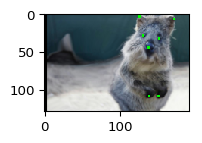

In [7]:
time_start = time.time()
batches_aug = list(aug.augment_batches(batches, background=True))  # background=True for multicore aug
time_end = time.time()

print("Augmentation done in %.2fs" % (time_end - time_start,))
ia.imshow(
    batches_aug[0].keypoints_aug[0].draw_on_image(
        batches_aug[0].images_aug[0]
    )
)

And that's it. Simply add `keypoints=<list of imgaug.augmentables.kps.KeypointsOnImage>` when instantiating an `UnnormalizedBatch` instance and the rest is handled by the library. The same can be done for bounding boxes (`bounding_boxes=<list of imgaug.augmentables.bbs.BoundingBoxesOnImage>`), heatmaps (`heatmaps=<list of imgaug.augmentables.heatmaps.HeatmapsOnImage>`) or segmentation maps (`segmentation_maps=<list of imgaug.augmentables.segmaps.SegmentationMapOnImage>`). Just make sure that the lists have the same length and entries with the same index actually belong to each other (e.g. image `0014059.jpg` and the keypoints for image `0014059.jpg`).

You might have noticed that the augmentation time here went up from ~30 seconds to ~80 seconds -- just by adding keypoints. That is because `PiecewiseAffine` uses an image based method for keypoint augmentation due to inaccuracies when transforming keypoints as coordinates. It is currently the slowest keypoint augmenter in the library (so avoid using `PiecewiseAffine` when augmenting keypoints or bounding boxes).

# Using Pool

`augment_batches()` is easy to use, but does not offer much customization. If you want to e.g. control the number of used CPU cores or the random number seed, `augmenter.pool()` is a simple alternative (and it is the backend that `augment_batches()` uses). The example below augments again the previously defined batches, this time with `pool()`. We configure the pool to use all CPU cores except one (`processes=-1`), restart child processes after 20 tasks (`maxtasksperchild=20`) and to start with a random number seed of `1`. The argument `maxtasksperchild` can be useful if you deal with memory leaks that lead to more and more memory consumption over time. If you don't have this problem, there is no reason to use the argument (and it does cost performance to use it).

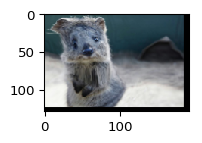

In [8]:
with aug.pool(processes=-1, maxtasksperchild=20, seed=1) as pool:
    batches_aug = pool.map_batches(batches)
ia.imshow(batches_aug[0].images_aug[0])

Note that we called `map_batches()` here exactly once to augment the input batches. In practice, we can call that command many times for each generated pool using different input batches -- and it is recommended to do so, because creating a new pool requires respawning the child processes, which does cost some time.

`augmenter.pool()` is a shortcut that creates an instance of `imgaug.multicore.Pool`, which again is a wrapper around python's `multiprocessing.Pool`. The wrapper deals mainly with the correct management of random states between child processes. The below example shows the usage of `imgaug.multicore.Pool`, using the same seed as in the `augmenter.pool()` example above and hence generating the same output.

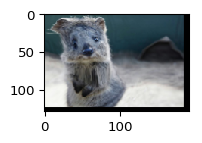

In [9]:
from imgaug import multicore

with multicore.Pool(aug, processes=-1, maxtasksperchild=20, seed=1) as pool:
    batches_aug = pool.map_batches(batches)

ia.imshow(batches_aug[0].images_aug[0])

# Using Pool with Generators

The two previous examples showed how to use lists with `imgaug`'s Pool. For large datasets, using generators can be more appropiate to avoid having to store the whole dataset in memory. This is trivially done by replacing `map_batches(<list>)` with `imap_batches(<generator>)`. The output of that function is also a generator.

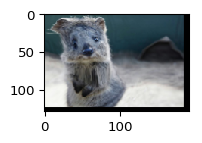

In [10]:
def create_generator(lst):
    for list_entry in lst:
        yield list_entry

my_generator = create_generator(batches)

with aug.pool(processes=-1, seed=1) as pool:
    batches_aug = pool.imap_batches(my_generator)

    for i, batch_aug in enumerate(batches_aug):
        if i == 0:
            ia.imshow(batch_aug.images_aug[0])
        # do something else with the batch here

Note that if you don't need your batches to be returned in the same order as you provided them, you can also use `imap_batches_unordered()` instead of `imap_batches()`. The unordered method tends to be faster.

# Rate-Limiting Pool to decrease maximum RAM requirements

*New in version 0.3.0.*

By default, pool will *greedely* load (and augment) as many batches as possible from generators. There is no rate-limiting that restricts how many augmented batches are at most allowed to "wait" in the pipeline. That means that in the worst case (when the model trains very slowly, while the augmentation is very fast) the whole augmented dataset could be waiting to be retrieved, which would potentially lead to high RAM usage, depending on how large the dataset is.

To fix this problem, the argument `output_buffer_size` can be used. The value controls how many batches are at most allowed to exist within the whole augmentation pipeline, i.e. `imap_batches(gen)` will load new batches from `gen` until `output_buffer_size` batches are reached and then only load another batch from `gen` whenever it has successfully yielded an augmented batch.

Below code shows an example. It is similar to the one above, but uses an augmentation pipeline that produces batches faster than they are consumed. Messages are printed that show exactly when batches are loaded and when they are requested from the augmentation pipeline. To limit the RAM requirements of this fast pipeline, `output_buffer_size=5` is used, restricting the allowed number of waiting batches to five. Note that batches in imgaug contain the images before *and* after augmentation, so the effective RAM requirement is here `5*2*I`, where `I` is the size of a single image. In practice that value should be viewed as a lower bound for the actual RAM demands, as e.g. copying data to background processes could temporarily double the requirements.

In [11]:
import time

# We use a single, very fast augmenter here to show that batches
# are only loaded once there is space again in the buffer.
pipeline = iaa.Fliplr(0.5)

def create_generator(lst):
    for list_entry in lst:
        print("Loading next unaugmented batch...")
        yield list_entry

# only use 25 batches here, which is enough to show the effect
my_generator = create_generator(batches[0:25])

with pipeline.pool(processes=-1, seed=1) as pool:
    batches_aug = pool.imap_batches(my_generator, output_buffer_size=5)

    print("Requesting next augmented batch...")
    for i, batch_aug in enumerate(batches_aug):
        # sleep here for a while to simulate a slowly training model
        time.sleep(0.1)

        if i < len(batches)-1:
            print("Requesting next augmented batch...")

Requesting next augmented batch...
Loading next unaugmented batch...
Loading next unaugmented batch...
Loading next unaugmented batch...
Loading next unaugmented batch...
Loading next unaugmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Requesting next augmented batch...
Loading next unaugmented batch...
Re

The method `imap_batches_unordered()` also supports `output_buffer_size`. However, `map_batches()` does not support the argument and always augments the whole input list.

## Conclusion

So to use multicore augmentation with `imgaug` just do the following:
  * Convert your data to instances of `imgaug.Batch`. Make sure that corresponding data has the same list index within the batch, e.g. images and their corresponding keypoints.
  * Call `augmenter.augment_batches(batches, background=True)`. This returns a generator.
  * Use `augmenter.pool([processes], [maxtasksperchild], [seed])` if you need more control or want to use a generator as input. Call `pool.map_batches(list)` or `pool.imap_batches(generator)` on the pool.
  * Avoid implementing your own multicore system or using another library for that as it is easy to mess up.